In [255]:
import numpy as np
from scipy.constants import e, m_p, m_e, c, epsilon_0, m_n, k as kb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle

plt.rcParams.update({
    # Color cycle
    "axes.prop_cycle": cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']),

    # Figure size
    "figure.figsize": (4, 3),

    # X ticks
    "xtick.direction": "in",
    "xtick.major.size": 3,
    "xtick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.visible": True,
    "xtick.top": True,

    # Y ticks
    "ytick.direction": "in",
    "ytick.major.size": 3,
    "ytick.major.width": 0.5,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.visible": True,
    "ytick.right": True,

    # Axes & lines
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 1.0,

    # Font & math
    "font.family": "sans-serif",
    #"mathtext.fontset": "dejavuserif",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",

    # Legend & saving
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})


In [336]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2570 / Axis length                                    
NAXIS2  =                 4611 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2006-03-20T14:56:47' / Date FITS file was generated                  
IRAF-TLM= '14:56:45 (20/03/2006)' / Time of last modification                   
OBJECT  = 'Lockman_mosaic_r_1046+5902 - DelRA =   0.0, DelDec =   0.0' / Name of
NEXTEND =                   

In [337]:
%matplotlib widget

# Preliminary

## Plot the original image 

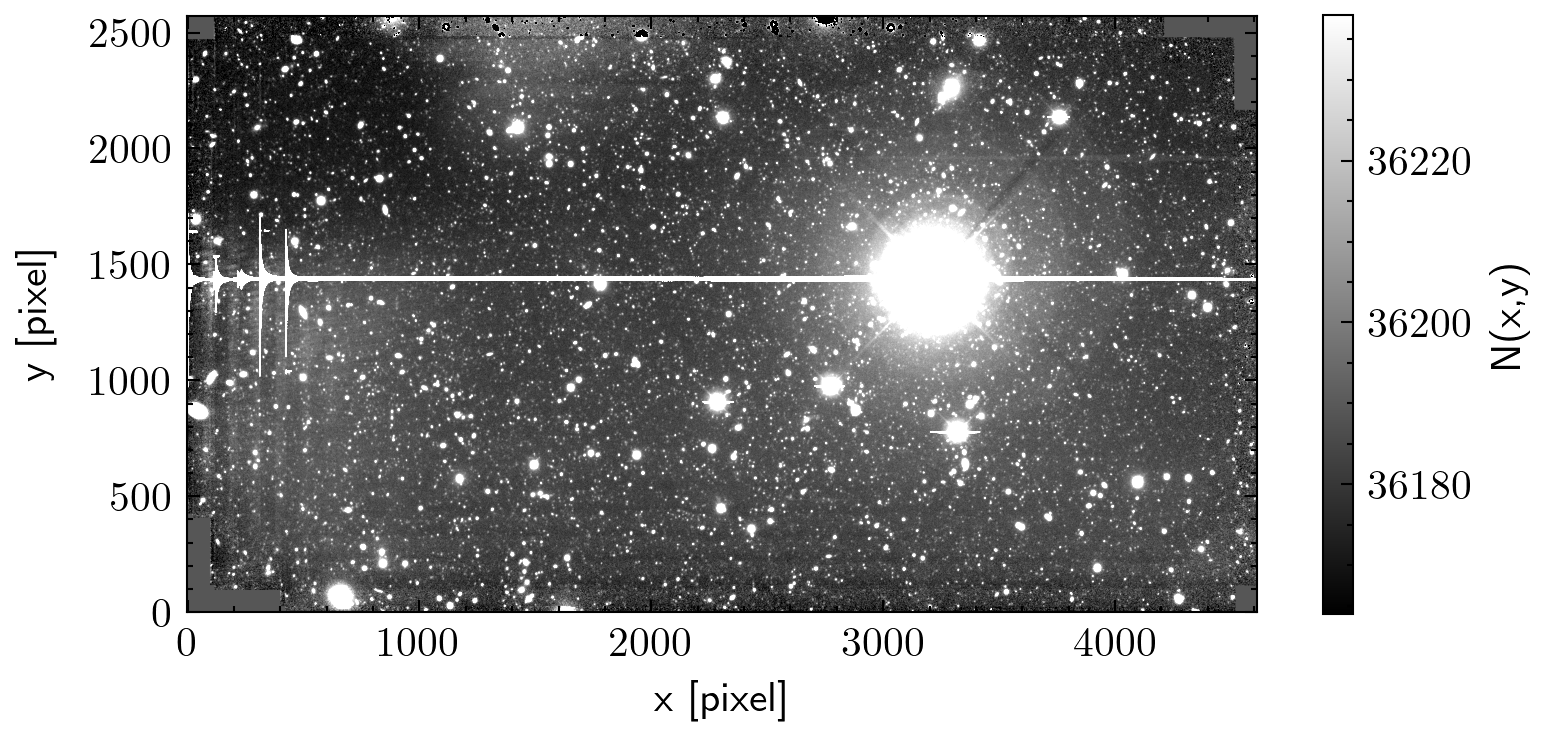

In [205]:
# Load the FITS file
with fits.open("data/Fits_Data/mosaic.fits") as hdul:
    image_data = hdul[0].data # this contains the count in each pixel
    header = hdul[0].header

# Apply scaling
# REAL = TAPE*BSCALE + BZERO                     
scaled_image = image_data.T * header.get('BSCALE', 1) + header.get('BZERO', 0)

# Get aspect ratio (width / height)
ny, nx = scaled_image.shape
aspect_ratio = nx / ny
enlarge = 1

# Plot
plt.figure(figsize=(3 * aspect_ratio * enlarge, 3 * enlarge), dpi=300)
plt.imshow(
    scaled_image,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95)
)
plt.title('')
plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

## Plot histogram for the original image (zoom into the Gaussian region)

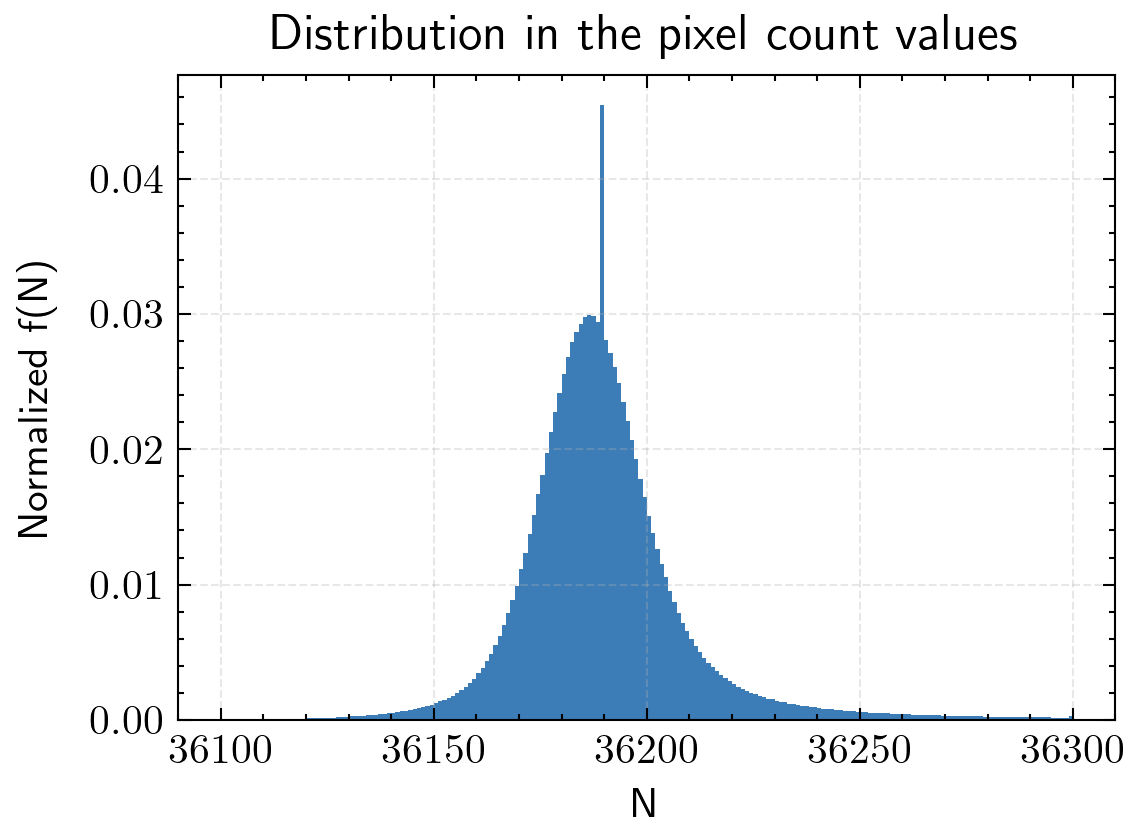

Mean: 36189.056
Std:  19.263


In [297]:
# Flatten to 1D array of counts
pixels = scaled_image.flatten()

# Define range
min_count, max_count = 36.1e3, 36.3e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Compute bins with width = 1
bin_edges = np.arange(min_count, max_count + 1, 1)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=bin_edges, alpha=0.8, density=True)
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")

# De-noising / cleaning

## Crop out the noisy part

Fraction of lost data: 0.1734871863679055


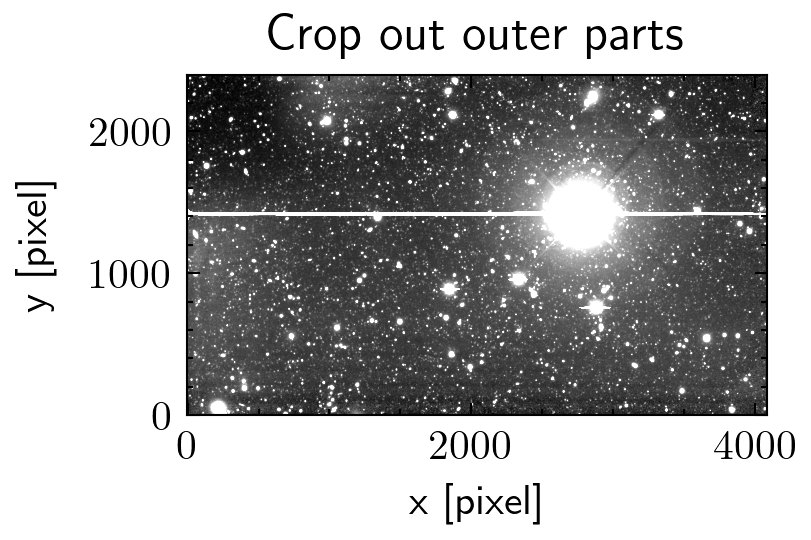

In [350]:
# Crop out the border part
crop = scaled_image[20:-150, 440:-90]
aspect_ratio_new = crop.shape[1] / crop.shape[0]

# Calculate percentage of data lost
print('Fraction of lost data:', 1 - crop.size / scaled_image.size)

# Plot again
plt.figure(figsize=(2 * aspect_ratio_new, 2), dpi=300)
plt.imshow(
    crop,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(crop, 5),
    vmax=np.percentile(crop, 95)
)

plt.title('Crop out outer parts')
# plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()


In [376]:
# --- Define function ---
def mask_circle(image, center, radius, mean, std):
    x0, y0 = center
    masked = image.copy()
    yy, xx = np.ogrid[:masked.shape[0], :masked.shape[1]]
    circle_mask = (xx - x0)**2 + (yy - y0)**2 <= radius**2
    masked[circle_mask] = np.random.normal(mean, std, size=masked[circle_mask].shape)
    return masked

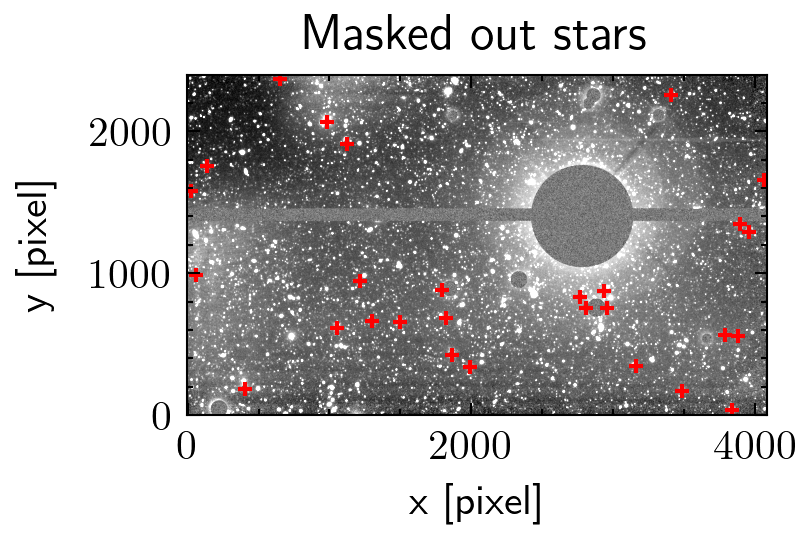

In [458]:
# Parameters for normal distribution
mean_val = 36189
std_val = 19

# --- Apply masking ---
masked = crop.copy()

# Manual masking for larger objects 
masked[1366:1455, :] = np.random.normal(mean_val, std_val, size=masked[1366:1455, :].shape)
masked = mask_circle(masked, center=(2780, 1400), radius=360, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(2880, 755), radius=65, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(1850, 890), radius=55, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(2335, 953), radius=60, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(3318, 2112), radius=42, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(3658, 538), radius=35, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(225, 44), radius=60, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(2860, 2250), radius=50, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(2820, 2180), radius=30, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(2820, 2200), radius=30, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(2840, 2200), radius=30, mean=mean_val, std=std_val)
masked = mask_circle(masked, center=(1870, 2110), radius=34, mean=mean_val, std=std_val)


# --- Detect remaining saturated regions ---
bright_mask = masked > 5e4
labels, num = snd.label(bright_mask, structure=np.ones((3,3)))
centers = snd.center_of_mass(masked, labels, np.arange(1, num+1))
yy = [c[0] for c in centers]
xx = [c[1] for c in centers]

# --- Patch each center with small circular mask (radius ~20 px) ---
for x, y in zip(xx, yy):  # your mask_circle expects (x, y)
    masked = mask_circle(masked, center=(x, y), radius=22, mean=mean_val, std=std_val)

# --- Plot final masked image ---
plt.figure(figsize=(2 * aspect_ratio_new, 2), dpi=300)
plt.imshow(
    masked,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(masked, 5),
    vmax=np.percentile(masked, 95)
)

# Overlay crosses at the centers for verification
plt.scatter(xx, yy, s=10, marker='+', c='red', linewidths=1)

plt.title('Masked out stars')
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()


## Replot histogram

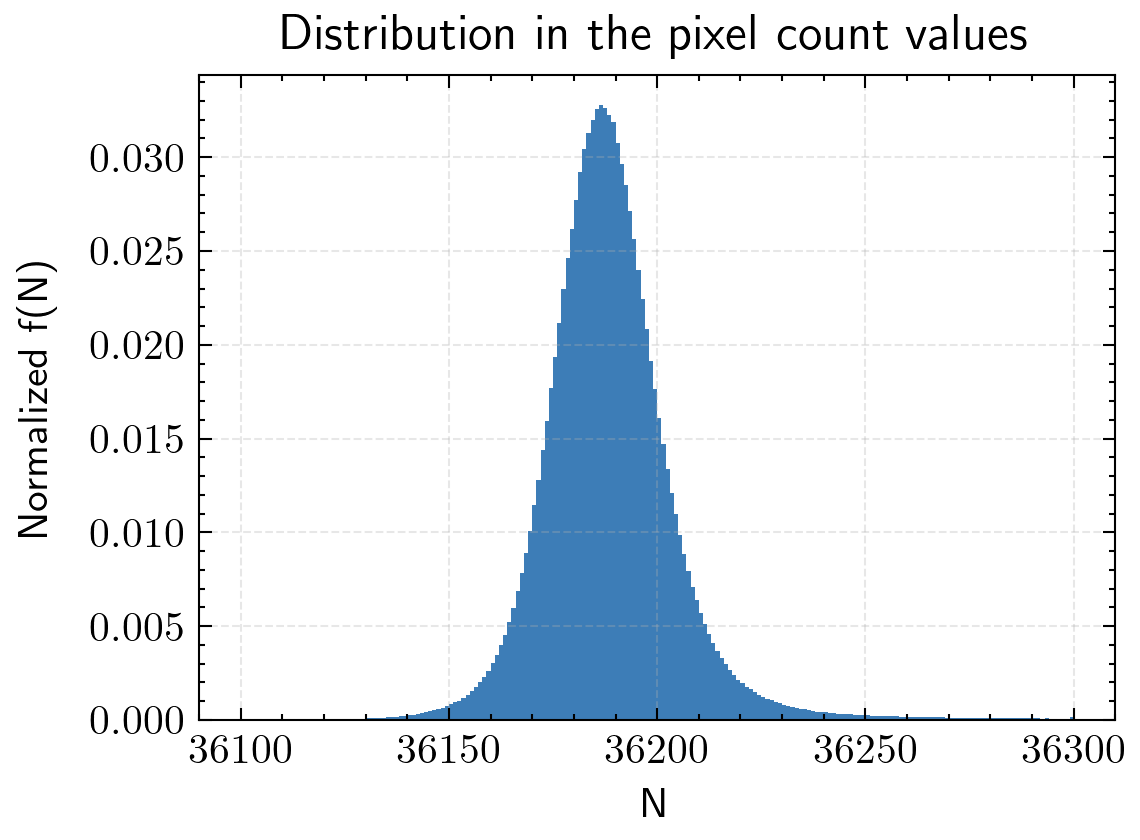

Mean: 36187.993
Std:  15.681


In [459]:
# Flatten to 1D array of counts
pixels = masked.flatten()

# Define range
min_count, max_count = 36.1e3, 36.3e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Compute bins with width = 1
bin_edges = np.arange(min_count, max_count + 1, 1)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=bin_edges, alpha=0.8, density=True)
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")

# Crop out a portion of the image to test code

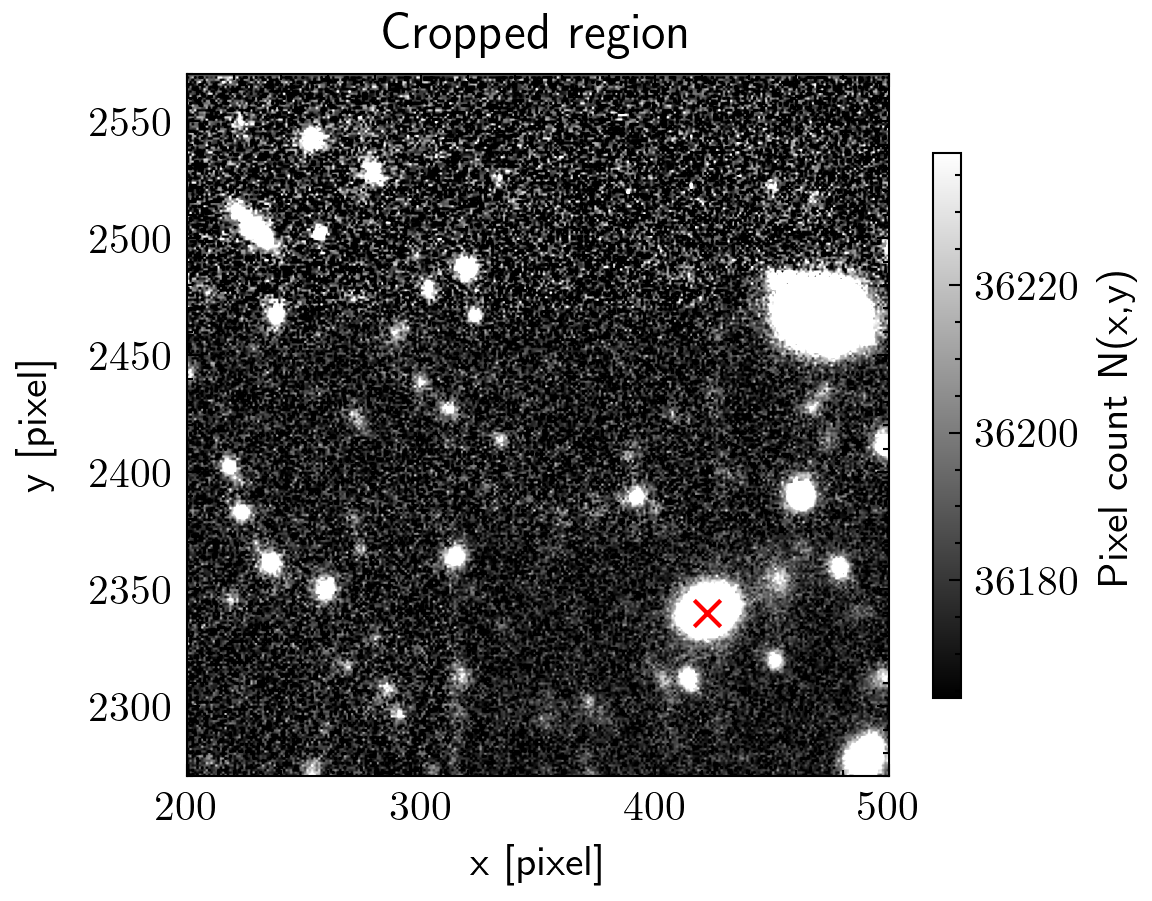

In [270]:
# --- region setup ---
size = 300
ny, nx = scaled_image.shape  
crop = scaled_image[ny - size : ny, 200 : size + 200]

# brightest pixel (absolute coords)
y_local, x_local = np.unravel_index(np.argmax(crop), crop.shape)
x_abs = 200 + x_local
y_abs = (ny - size) + y_local
max_val = crop[y_local, x_local]

# --- plot with circle ---
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
im = ax.imshow(
    crop,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95),
    extent=[200, size + 200, ny - size, ny]
)

ax.scatter(x_abs, y_abs, color='red', marker='x', s=40)
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]', labelpad=8)
ax.set_title(f'Cropped region')
fig.colorbar(im, ax=ax, label='Pixel count N(x,y)', shrink=0.5)
plt.tight_layout()
plt.show()
